In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['mathtext.default'] = 'regular'
#%matplotlib widget
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF, InterRDF_s
import MDAnalysis.transformations
from scipy.io import mmwrite
from scipy.interpolate import CubicSpline
import scipy.stats as st
from scipy.stats import linregress

import pyblock

/u/home/w/wborrell/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
u47 = mda.Universe('./vm_cmt_data/h2o_47_ecom.xyz','./vm_cmt_data/h2o_47_ecom.xyz', dt=0.0005)
u64 = mda.Universe('./vm_cmt_data/h2o_64_ecom.xyz','./vm_cmt_data/h2o_64_ecom.xyz', dt=0.0005)
u128 = mda.Universe('./vm_cmt_data/h2o_ecom.xyz','./vm_cmt_data/h2o_ecom.xyz', dt=0.0005)

In [3]:
dim47 = [11.212, 11.212, 11.212, 90, 90, 90]
transform47 = mda.transformations.boxdimensions.set_dimensions(dim47)
u47.trajectory.add_transformations(transform47)

dim128 = [15.66, 15.66, 15.66, 90, 90, 90]
transform128 = mda.transformations.boxdimensions.set_dimensions(dim128)
u128.trajectory.add_transformations(transform128)

dim64= [12.519, 12.519, 12.519, 90, 90, 90]
transform64 = mda.transformations.boxdimensions.set_dimensions(dim64)
u64.trajectory.add_transformations(transform64)

In [4]:
br47, br64, br128 = np.array([11.212, 12.519, 15.66])/2

In [5]:
bc47, bc64, bc128 = [35, 25, 60]

In [6]:
gr_128_f = np.loadtxt('./vm_cmt_data/gr_128.dat')
gr_128_yindv = np.loadtxt('./vm_cmt_data/indv_gr_128.dat')

gr_64_f = np.loadtxt('./vm_cmt_data/gr_64.dat')
gr_64_yindv = np.loadtxt('./vm_cmt_data/indv_gr_64.dat')

gr_47_f = np.loadtxt('./vm_cmt_data/gr_47.dat')
gr_47_yindv = np.loadtxt('./vm_cmt_data/indv_gr_47.dat')

# Helper Functions

In [7]:
def rdf_bin(u, bc, max, p1, p2):
    rdf = InterRDF(u.select_atoms(p1), u.select_atoms(p2), range=[0.0,max])
    rdf.run()
    plt.plot(rdf.results.bins, rdf.results.rdf)
    plt.show()

In [8]:
def weight(r, br):
    return 4*np.pi*r**2*(1-((3*(r/br))/(2))+(((r/br)**3)/(2)))

In [9]:
def vm(gofr, br, end_int, start_int=0):
    weights = [weight(i, br) for i in gofr.bins]
    intf = CubicSpline(x=gofr.bins, y=(weights*(gofr.rdf-1)), bc_type='natural')
    int = (1*10**(-30))*intf.integrate(a=start_int, b=end_int)
    t1 = (1.380649*10**(-23))*298*(50*10**(-6))*(1/101325)
    return (t1 - int)*(6.022*10**(23))*1000000

In [10]:
def vm_exptK(gofr, br, end_int, start_int=0):
    weights = [weight(i, br) for i in gofr.bins]
    intf = CubicSpline(x=gofr.bins, y=(weights*(gofr.rdf-1)), bc_type='natural')
    int = (1*10**(-30))*intf.integrate(a=start_int, b=end_int)
    t1 = (1.380649*10**(-23))*298*(4.58496*10**(-5))*(1/101325)
    return (t1 - int)*(6.022*10**(23))*1000000

In [11]:
def vm_fwK(gofr, br, end_int, start_int=0):
    weights = [weight(i, br) for i in gofr.bins]
    intf = CubicSpline(x=gofr.bins, y=(weights*(gofr.rdf-1)), bc_type='natural')
    int = (1*10**(-30))*intf.integrate(a=start_int, b=end_int)
    t1 = (1.380649*10**(-23))*298*(4.50*10**(-5))*(1/101325)
    return (t1 - int)*(6.022*10**(23))*1000000

In [12]:
def vm_pbe0K(gofr, br, end_int, start_int=0):
    weights = [weight(i, br) for i in gofr.bins]
    intf = CubicSpline(x=gofr.bins, y=(weights*(gofr.rdf-1)), bc_type='natural')
    int = (1*10**(-30))*intf.integrate(a=start_int, b=end_int)
    t1 = (1.380649*10**(-23))*298*(35*10**(-6))*(1.01325*10**(-6))*(1/101325)
    return (t1 - int)*(6.022*10**(23))*1000000

In [13]:
def vm_pbe0K2(gofr, br, end_int, start_int=0):
    weights = [weight(i, br) for i in gofr.bins]
    intf = CubicSpline(x=gofr.bins, y=(weights*(gofr.rdf-1)), bc_type='natural')
    int = (1*10**(-30))*intf.integrate(a=start_int, b=end_int)
    t1 = (1.380649*10**(-23))*298*(30*10**(-6))*(1.01325*10**(-6))*(1/101325)
    return (t1 - int)*(6.022*10**(23))*1000000

In [14]:
def vm_pbe0K2_rg(gofr_y, gofr_x, br, end_int, start_int=0):
    weights = [weight(i, br) for i in gofr_x]
    intf = CubicSpline(x=gofr_x, y=(weights*(gofr_y-1)), bc_type='natural')
    inte = (1*10**(-30))*intf.integrate(a=start_int, b=end_int)
    t1 = (1.380649*10**(-23))*298*(30*10**(-6))*(1.01325*10**(-6))*(1/101325)
    return (t1 - inte)*(6.022*10**(23))*1000000

In [15]:
def vm_pbe0K2_rg_debug(goft_y, gofr_x, br, end_int, start_int=0):
    weights = [weight(i, br) for i in gofr_x]
    intf = CubicSpline(x=gofr_x, y=(weights*(goft_y-1)), bc_type='natural')
    inte = (1*10**(-30))*intf.integrate(a=start_int, b=end_int)
    t1 = (1.380649*10**(-23))*298*(30*10**(-6))*(1.01325*10**(-6))*(1/101325)
    return [(t1 - inte)*(6.022*10**(23))*1000000, t1, inte]

In [16]:
def all_rdfs(uni, br, end, nbins, fname='name Zn', sname='name He'):
    rdfs = []
    for i in range(len(range(0,len(uni.trajectory)))-1):
        rdfs.append(InterRDF(uni.select_atoms(fname), uni.select_atoms(sname), range=[0.0,br], nbins=nbins).run(start=range(0,len(uni.trajectory))[i], stop=range(0,len(uni.trajectory))[i+1]))
    return rdfs

In [17]:
def block_avg_err(data):
    reblk_dat = pyblock.blocking.reblock(data)
    op = pyblock.blocking.find_optimal_block(len(data), reblk_dat)
    if np.isnan(op[0]):
        return reblk_dat[np.argmax(np.array([reblk_dat[i][4] for i in range(len(reblk_dat))]))]
    else:
        return reblk_dat[op[0]]

In [18]:
blk_mean_err = lambda dat : np.array([block_avg_err(np.array(dat).T[-1])[2], 2*block_avg_err(np.array(dat).T[-1])[4]])

In [19]:
def stdDU(dat):
    return [np.array(list(map(np.mean, np.array(dat).T)))-np.array(list(map(np.std, np.array(dat).T))), np.array(list(map(np.mean, np.array(dat).T)))+np.array(list(map(np.std, np.array(dat).T)))]

In [20]:
def semDU(dat):
    return [np.array(list(map(np.mean, np.array(dat).T)))-[np.std(np.array(dat).T[i])/np.sqrt(len(np.array(dat).T[i])) for i in range(len(np.array(dat).T))], np.array(list(map(np.mean, np.array(dat).T)))+[np.std(np.array(dat).T[i])/np.sqrt(len(np.array(dat).T[i])) for i in range(len(np.array(dat).T))]]

# RDFs

## Ken's RDFs

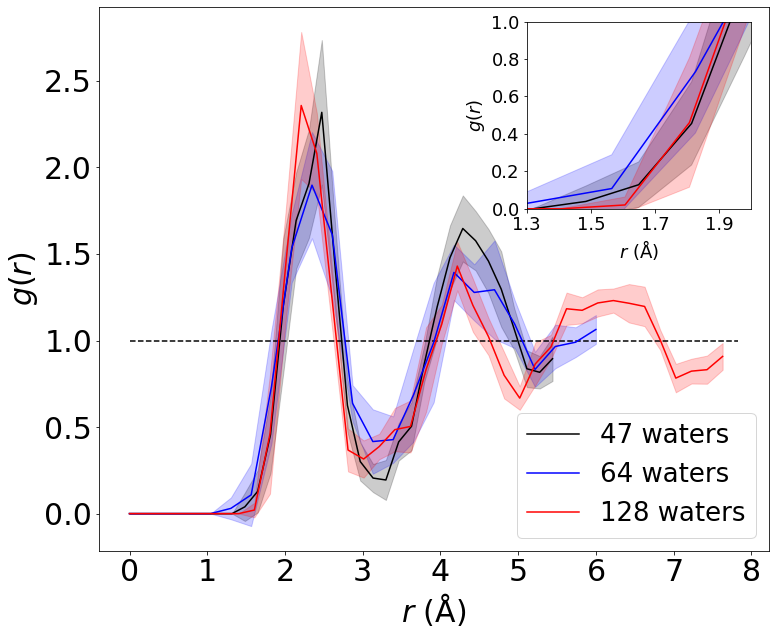

In [22]:
plt.figure(figsize=(12,10))

plt.plot(gr_47_f[:,0], gr_47_f[:,1], color='k', label='47 waters')
plt.fill_between(gr_47_f[:,0], gr_47_f[:,1]-gr_47_f[:,2], gr_47_f[:,1]+gr_47_f[:,2], alpha=0.2, color='k')

plt.plot(gr_64_f[:,0], gr_64_f[:,1], color='blue', label='64 waters')
plt.fill_between(gr_64_f[:,0], gr_64_f[:,1]-gr_64_f[:,2], gr_64_f[:,1]+gr_64_f[:,2], alpha=0.2, color='blue')

plt.plot(gr_128_f[:,0], gr_128_f[:,1], color='red', label='128 waters')
plt.fill_between(gr_128_f[:,0], gr_128_f[:,1]-gr_128_f[:,2], gr_128_f[:,1]+gr_128_f[:,2], alpha=0.2, color='red')

plt.legend(fontsize=26, loc='lower right')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('$\it{r}$ ($\AA$)', fontsize=30)
plt.ylabel('$\it{g}$($\it{r}$)', fontsize=30)
plt.hlines(1.0, 0,br128, colors='k', linestyles='--')

left, bottom, width, height = [0.62, 0.6, 0.26, 0.26]
plt.axes([left, bottom, width, height])
plt.plot(gr_47_f[:,0], gr_47_f[:,1], color='k', label='47 waters')
plt.fill_between(gr_47_f[:,0], gr_47_f[:,1]-gr_47_f[:,2], gr_47_f[:,1]+gr_47_f[:,2], alpha=0.2, color='k')

plt.plot(gr_64_f[:,0], gr_64_f[:,1], color='blue', label='64 waters')
plt.fill_between(gr_64_f[:,0], gr_64_f[:,1]-gr_64_f[:,2], gr_64_f[:,1]+gr_64_f[:,2], alpha=0.2, color='blue')

plt.plot(gr_128_f[:,0], gr_128_f[:,1], color='red', label='128 waters')
plt.fill_between(gr_128_f[:,0], gr_128_f[:,1]-gr_128_f[:,2], gr_128_f[:,1]+gr_128_f[:,2], alpha=0.2, color='red')
plt.xlim([1.3,2.])
plt.ylim([0,1])
plt.xlabel('$\it{r}$ ($\AA$)', fontsize=18)
plt.ylabel('$\it{g}$($\it{r}$)', fontsize=18)
plt.xticks(ticks=np.arange(1.3,2.1,0.2),fontsize=18)
plt.yticks(fontsize=18)

#plt.savefig('./vm_cmt_data/figs/grs_2tba.pdf', format='pdf')
plt.show()

## MDanalysis RDFs

In [21]:
ardfs47 = all_rdfs(u47, br47, br47, bc47)
ardfs64 = all_rdfs(u64, br64, br64, bc64)
ardfs128 = all_rdfs(u128, br128, br128, bc128)

In [22]:
map_blk_avg = lambda x : block_avg_err(x)[2]

In [23]:
map_blk_err = lambda x : block_avg_err(x)[4]

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn

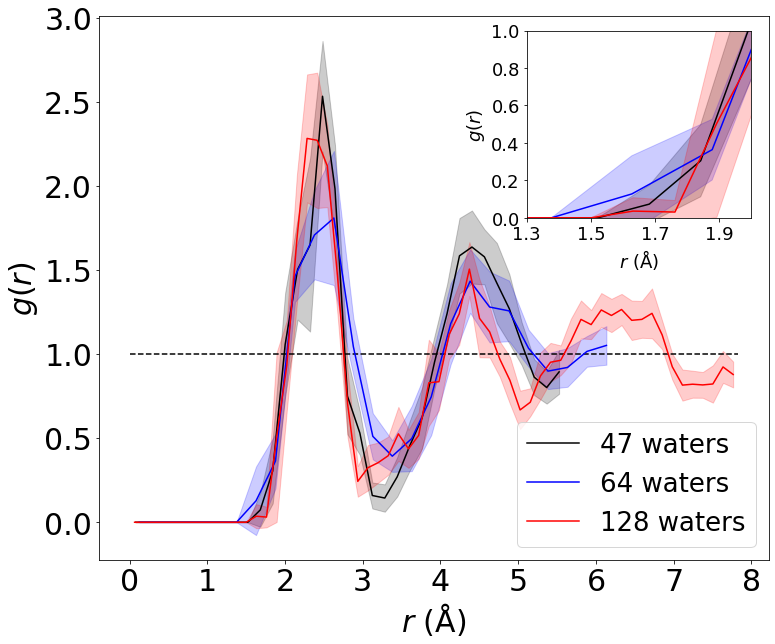

In [25]:
plt.figure(figsize=(12,10))

plt.plot(ardfs47[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T))),
        label='47 waters', color='k')
plt.fill_between(ardfs47[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T)))-2*np.array(list(map(map_blk_err, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T))),
                 np.array(list(map(map_blk_avg, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T)))+2*np.array(list(map(map_blk_err, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T)))
                 , alpha=0.2, color='k')

plt.plot(ardfs64[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs64[i].rdf for i in range(len(ardfs64))]).T))),
        label='64 waters', color='blue')
plt.fill_between(ardfs64[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs64[i].rdf for i in range(len(ardfs64))]).T)))-2*np.array(list(map(map_blk_err, np.array([ardfs64[i].rdf for i in range(len(ardfs64))]).T))),
                 np.array(list(map(map_blk_avg, np.array([ardfs64[i].rdf for i in range(len(ardfs64))]).T)))+2*np.array(list(map(map_blk_err, np.array([ardfs64[i].rdf for i in range(len(ardfs64))]).T)))
                 , alpha=0.2, color='blue')

plt.plot(ardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs128[i].rdf for i in range(len(ardfs128))]).T))),
        label='128 waters', color='r')
plt.fill_between(ardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs128[i].rdf for i in range(len(ardfs128))]).T)))-2*np.array(list(map(map_blk_err, np.array([ardfs128[i].rdf for i in range(len(ardfs128))]).T))),
                 np.array(list(map(map_blk_avg, np.array([ardfs128[i].rdf for i in range(len(ardfs128))]).T)))+2*np.array(list(map(map_blk_err, np.array([ardfs128[i].rdf for i in range(len(ardfs128))]).T)))
                 , alpha=0.2, color='r')

plt.legend(fontsize=26, loc='lower right')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('$\it{r}$ ($\AA$)', fontsize=30)
plt.ylabel('$\it{g}$($\it{r}$)', fontsize=30)
plt.hlines(1.0, 0,br128, colors='k', linestyles='--')

left, bottom, width, height = [0.62, 0.6, 0.26, 0.26]
plt.axes([left, bottom, width, height])

plt.plot(ardfs47[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T))),
        label='47 waters', color='k')
plt.fill_between(ardfs47[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T)))-2*np.array(list(map(map_blk_err, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T))),
                 np.array(list(map(map_blk_avg, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T)))+2*np.array(list(map(map_blk_err, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T)))
                 , alpha=0.2, color='k')

plt.plot(ardfs64[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs64[i].rdf for i in range(len(ardfs64))]).T))),
        label='64 waters', color='blue')
plt.fill_between(ardfs64[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs64[i].rdf for i in range(len(ardfs64))]).T)))-2*np.array(list(map(map_blk_err, np.array([ardfs64[i].rdf for i in range(len(ardfs64))]).T))),
                 np.array(list(map(map_blk_avg, np.array([ardfs64[i].rdf for i in range(len(ardfs64))]).T)))+2*np.array(list(map(map_blk_err, np.array([ardfs64[i].rdf for i in range(len(ardfs64))]).T)))
                 , alpha=0.2, color='blue')

plt.plot(ardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs128[i].rdf for i in range(len(ardfs128))]).T))),
        label='128 waters', color='r')
plt.fill_between(ardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs128[i].rdf for i in range(len(ardfs128))]).T)))-2*np.array(list(map(map_blk_err, np.array([ardfs128[i].rdf for i in range(len(ardfs128))]).T))),
                 np.array(list(map(map_blk_avg, np.array([ardfs128[i].rdf for i in range(len(ardfs128))]).T)))+2*np.array(list(map(map_blk_err, np.array([ardfs128[i].rdf for i in range(len(ardfs128))]).T)))
                 , alpha=0.2, color='r')

plt.xlim([1.3,2.])
plt.ylim([0,1])
plt.xlabel('$\it{r}$ ($\AA$)', fontsize=18)
plt.ylabel('$\it{g}$($\it{r}$)', fontsize=18)
plt.xticks(ticks=np.arange(1.3,2.1,0.2),fontsize=18)
plt.yticks(fontsize=18)

#plt.legend()
#plt.savefig('./vm_cmt_data/figs/grs_2tba_newBins.pdf', format='pdf')
plt.show()

# VM Values

## Original 

In [73]:
grs47_orig = all_rdfs(u47, br47, br47, 57)
grs64_orig = all_rdfs(u64, br64, br64, 63)
grs128_orig = all_rdfs(u128, br128, br128, 79)

In [74]:
ri47 = [[vm_pbe0K2(grs47_orig[gr], br47, np.arange(0,br47+.1,0.1)[i]) for i in range(len(np.arange(0,br47+.1,0.1)))] for gr in range(len(grs47_orig))]
ri64 = [[vm_pbe0K2(grs64_orig[gr], br64, np.arange(0,br64+.1,0.1)[i]) for i in range(len(np.arange(0,br64+.1,0.1)))] for gr in range(len(grs64_orig))]
ri128 = [[vm_pbe0K2(grs128_orig[gr], br128, np.arange(0,br128+.1,0.1)[i]) for i in range(len(np.arange(0,br128+.1,0.1)))] for gr in range(len(grs128_orig))]

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)


In [75]:
list(map(blk_mean_err, [ri47, ri64, ri128]))

[array([7.91725394, 0.63902292]),
 array([7.56356718, 1.46766901]),
 array([12.94139194,  1.82459975])]

## w/ new Grs

In [72]:
[np.unique(list(map(len, gr_47_yindv))), len(gr_47_f)]

[array([34]), 34]

In [73]:
[np.unique(list(map(len, gr_64_yindv))), len(gr_64_f)]

[array([24]), 24]

In [74]:
[np.unique(list(map(len, gr_128_yindv))), len(gr_128_f)]

[array([39]), 39]

In [66]:
ri47_new = [[vm_pbe0K2_rg(gr_47_yindv[gr], gr_47_f[:,0], br47, np.arange(0,br47+.1,0.1)[i]) for i in range(len(np.arange(0,br47+.1,0.1)))] for gr in range(len(gr_47_yindv))]
ri64_new = [[vm_pbe0K2_rg(gr_64_yindv[gr], gr_64_f[:,0], br64, np.arange(0,br64+.1,0.1)[i]) for i in range(len(np.arange(0,br64+.1,0.1)))] for gr in range(len(gr_64_yindv))]
ri128_new = [[vm_pbe0K2_rg(gr_128_yindv[gr], gr_128_f[:,0], br128, np.arange(0,br128+.1,0.1)[i]) for i in range(len(np.arange(0,br128+.1,0.1)))] for gr in range(len(gr_128_yindv))]

In [60]:
list(map(blk_mean_err, [ri47_new, ri64_new, ri128_new]))

[array([6.8803971 , 0.58672054]),
 array([5.71182433, 1.27412472]),
 array([12.31480903,  1.77626354])]

In [61]:
ri47 = [[vm_pbe0K2_rg(gr_47_yindv[gr], gr_47_f[:,0], br47, np.arange(0,br47+.1,0.1)[i]) for i in range(len(np.arange(0,br47+.1,0.1)))] for gr in range(len(gr_47_yindv))]
ri64 = [[vm_pbe0K2_rg(gr_64_yindv[gr], gr_64_f[:,0], br64, np.arange(0,br64+.1,0.1)[i]) for i in range(len(np.arange(0,br64+.1,0.1)))] for gr in range(len(gr_64_yindv))]
ri128 = [[vm_pbe0K2_rg(gr_128_yindv[gr], gr_128_f[:,0], br128, np.arange(0,br128+.1,0.1)[i]) for i in range(len(np.arange(0,br128+.1,0.1)))] for gr in range(len(gr_128_yindv))]

In [27]:
list(map(np.mean, [np.array(ri47).T[-1], np.array(ri64).T[-1], np.array(ri128).T[-1]]))

NameError: name 'ri47' is not defined

## MDAnaylsis gr

In [41]:
vmb47 = block_avg_err(np.array([vm_pbe0K2_rg(ardfs47[i].rdf, ardfs47[i].bins, br47, br47) for i in range(len(ardfs47))]))
vmb64 = block_avg_err(np.array([vm_pbe0K2_rg(ardfs64[i].rdf, ardfs64[i].bins, br64, br64) for i in range(len(ardfs64))]))
vmb128 = block_avg_err(np.array([vm_pbe0K2_rg(ardfs128[i].rdf, ardfs128[i].bins, br128, br128) for i in range(len(ardfs128))]))

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)


In [42]:
np.array([[vmb47[2], vmb47[4]], [vmb64[2], vmb64[4]], [vmb128[2], vmb128[4]]])

array([[ 7.87232849,  0.30446524],
       [ 7.47523493,  0.47406732],
       [12.87263487,  0.8999007 ]])

In [ ]:
[7.87, 7.48, 12.9]

# Running Integral and Contributions

## RI

### old Grs

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblo

<Figure size 864x720 with 0 Axes>

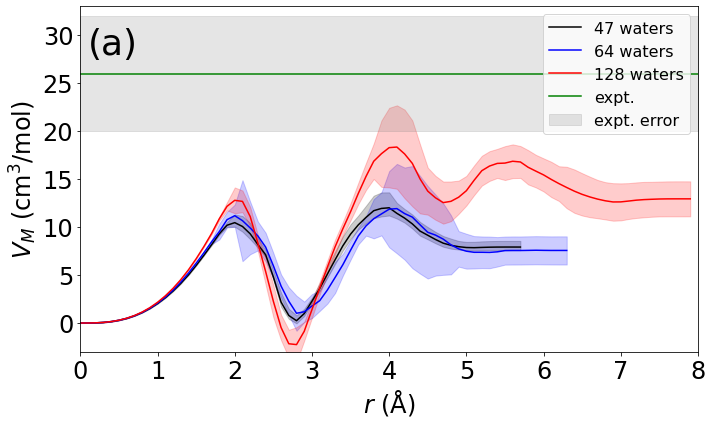

In [77]:
ri47 = [[vm_pbe0K2(grs47_orig[gr], br47, np.arange(0,br47+.1,0.1)[i]) for i in range(len(np.arange(0,br47+.1,0.1)))] for gr in range(len(grs47_orig))]
ri64 = [[vm_pbe0K2(grs64_orig[gr], br64, np.arange(0,br64+.1,0.1)[i]) for i in range(len(np.arange(0,br64+.1,0.1)))] for gr in range(len(grs64_orig))]
ri128 = [[vm_pbe0K2(grs128_orig[gr], br128, np.arange(0,br128+.1,0.1)[i]) for i in range(len(np.arange(0,br128+.1,0.1)))] for gr in range(len(grs128_orig))]
# with block avging

# make units not italic 
%matplotlib inline
plt.figure(figsize=(12,10))

plt.figure(figsize=(10,6))
plt.plot(np.arange(0,br47+.1,0.1), np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))]), color='k', label='47 waters')
plt.fill_between(np.arange(0,br47+.1,0.1), np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))])-np.array([np.array(block_avg_err(np.array(ri47).T[i])[4]) for i in range(len(np.array(ri47).T))]), 
                 np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))])+np.array([np.array(block_avg_err(np.array(ri47).T[i])[4]*2) for i in range(len(np.array(ri47).T))]), alpha=.2, color='k')

plt.plot(np.arange(0,br64+.1,0.1), np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))]), color='blue', label='64 waters')
plt.fill_between(np.arange(0,br64+.1,0.1), np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))])-np.array([np.array(block_avg_err(np.array(ri64).T[i])[4]*2) for i in range(len(np.array(ri64).T))]), 
                 np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))])+np.array([np.array(block_avg_err(np.array(ri64).T[i])[4]*2) for i in range(len(np.array(ri64).T))]), alpha=.2, color='blue')

plt.plot(np.arange(0,br128+.1,0.1), np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))]), color='red', label='128 waters')
plt.fill_between(np.arange(0,br128+.1,0.1), np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))])-np.array([np.array(block_avg_err(np.array(ri128).T[i])[4]*2) for i in range(len(np.array(ri128).T))]), 
                 np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))])+np.array([np.array(block_avg_err(np.array(ri128).T[i])[4]*2) for i in range(len(np.array(ri128).T))]), alpha=.2, color='red')

plt.plot([0,10], [26,26], label='expt.', color='g')
plt.fill_between([0,8], 20,32, alpha=.2, label='expt. error',color='grey')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('$\it{r}$ ($\AA$)', fontsize=24)
plt.ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
plt.ylim([-3,33])
plt.xlim([0,8])
plt.legend(fontsize=16, loc='upper right')
plt.text(.1, 28, '(a)', fontsize=36)
plt.tight_layout()
#plt.savefig('/mnt/d/DesktopFiles/UCLA_rsrch/schwartz/KB_molar_vol/figs/ri_ba.pdf', format='pdf')
plt.show()

### new grs

/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.

<Figure size 864x720 with 0 Axes>

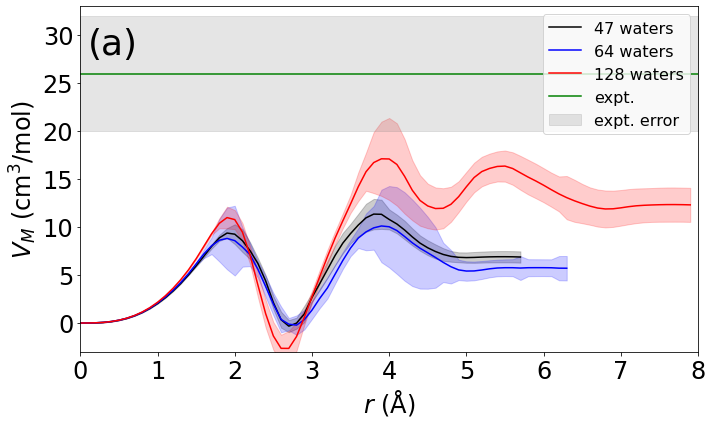

In [26]:
ri47 = [[vm_pbe0K2_rg(gr_47_yindv[gr], gr_47_f[:,0], br47, np.arange(0,br47+.1,0.1)[i]) for i in range(len(np.arange(0,br47+.1,0.1)))] for gr in range(len(gr_47_yindv))]
ri64 = [[vm_pbe0K2_rg(gr_64_yindv[gr], gr_64_f[:,0], br64, np.arange(0,br64+.1,0.1)[i]) for i in range(len(np.arange(0,br64+.1,0.1)))] for gr in range(len(gr_64_yindv))]
ri128 = [[vm_pbe0K2_rg(gr_128_yindv[gr], gr_128_f[:,0], br128, np.arange(0,br128+.1,0.1)[i]) for i in range(len(np.arange(0,br128+.1,0.1)))] for gr in range(len(gr_128_yindv))]
# with block avging

# make units not italic 
%matplotlib inline
plt.figure(figsize=(12,10))

plt.figure(figsize=(10,6))
plt.plot(np.arange(0,br47+.1,0.1), np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))]), color='k', label='47 waters')
plt.fill_between(np.arange(0,br47+.1,0.1), np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))])-np.array([np.array(block_avg_err(np.array(ri47).T[i])[4]*2) for i in range(len(np.array(ri47).T))]), 
                 np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))])+np.array([np.array(block_avg_err(np.array(ri47).T[i])[4]*2) for i in range(len(np.array(ri47).T))]), alpha=.2, color='k')

plt.plot(np.arange(0,br64+.1,0.1), np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))]), color='blue', label='64 waters')
plt.fill_between(np.arange(0,br64+.1,0.1), np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))])-np.array([np.array(block_avg_err(np.array(ri64).T[i])[4]*2) for i in range(len(np.array(ri64).T))]), 
                 np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))])+np.array([np.array(block_avg_err(np.array(ri64).T[i])[4]*2) for i in range(len(np.array(ri64).T))]), alpha=.2, color='blue')

plt.plot(np.arange(0,br128+.1,0.1), np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))]), color='red', label='128 waters')
plt.fill_between(np.arange(0,br128+.1,0.1), np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))])-np.array([np.array(block_avg_err(np.array(ri128).T[i])[4]*2) for i in range(len(np.array(ri128).T))]), 
                 np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))])+np.array([np.array(block_avg_err(np.array(ri128).T[i])[4]*2) for i in range(len(np.array(ri128).T))]), alpha=.2, color='red')

plt.plot([0,10], [26,26], label='expt.', color='g')
plt.fill_between([0,8], 20,32, alpha=.2, label='expt. error',color='grey')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('$\it{r}$ ($\AA$)', fontsize=24)
plt.ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
plt.ylim([-3,33])
plt.xlim([0,8])
plt.legend(fontsize=16, loc='upper right')
plt.text(.1, 28, '(a)', fontsize=36)
plt.tight_layout()
#plt.savefig('./vm_cmt_data/figs/ri_2tba.pdf', format='pdf')
plt.show()

### MDanalysis RDF

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblo

<Figure size 864x720 with 0 Axes>

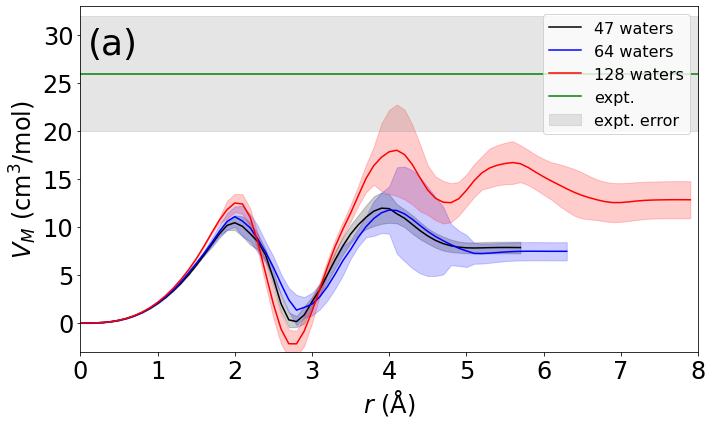

In [44]:
ri47 = [[vm_pbe0K2_rg(ardfs47[gr].results.rdf, ardfs47[gr].results.bins, br47, np.arange(0,br47+.1,0.1)[i]) for i in range(len(np.arange(0,br47+.1,0.1)))] for gr in range(len(ardfs47))]
ri64 = [[vm_pbe0K2_rg(ardfs64[gr].results.rdf, ardfs64[gr].results.bins, br64, np.arange(0,br64+.1,0.1)[i]) for i in range(len(np.arange(0,br64+.1,0.1)))] for gr in range(len(ardfs64))]
ri128 = [[vm_pbe0K2_rg(ardfs128[gr].results.rdf, ardfs128[gr].results.bins, br128, np.arange(0,br128+.1,0.1)[i]) for i in range(len(np.arange(0,br128+.1,0.1)))] for gr in range(len(ardfs128))]

# make units not italic 
%matplotlib inline
plt.figure(figsize=(12,10))

plt.figure(figsize=(10,6))
plt.plot(np.arange(0,br47+.1,0.1), np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))]), color='k', label='47 waters')
plt.fill_between(np.arange(0,br47+.1,0.1), np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))])-np.array([np.array(block_avg_err(np.array(ri47).T[i])[4]*2) for i in range(len(np.array(ri47).T))]), 
                 np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))])+np.array([np.array(block_avg_err(np.array(ri47).T[i])[4]*2) for i in range(len(np.array(ri47).T))]), alpha=.2, color='k')

plt.plot(np.arange(0,br64+.1,0.1), np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))]), color='blue', label='64 waters')
plt.fill_between(np.arange(0,br64+.1,0.1), np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))])-np.array([np.array(block_avg_err(np.array(ri64).T[i])[4]*2) for i in range(len(np.array(ri64).T))]), 
                 np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))])+np.array([np.array(block_avg_err(np.array(ri64).T[i])[4]*2) for i in range(len(np.array(ri64).T))]), alpha=.2, color='blue')

plt.plot(np.arange(0,br128+.1,0.1), np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))]), color='red', label='128 waters')
plt.fill_between(np.arange(0,br128+.1,0.1), np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))])-np.array([np.array(block_avg_err(np.array(ri128).T[i])[4]*2) for i in range(len(np.array(ri128).T))]), 
                 np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))])+np.array([np.array(block_avg_err(np.array(ri128).T[i])[4]*2) for i in range(len(np.array(ri128).T))]), alpha=.2, color='red')

plt.plot([0,10], [26,26], label='expt.', color='g')
plt.fill_between([0,8], 20,32, alpha=.2, label='expt. error',color='grey')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('$\it{r}$ ($\AA$)', fontsize=24)
plt.ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
plt.ylim([-3,33])
plt.xlim([0,8])
plt.legend(fontsize=16, loc='upper right')
plt.text(.1, 28, '(a)', fontsize=36)
plt.tight_layout()
#plt.savefig('./vm_cmt_data/figs/ri_2tba_newBins.pdf', format='pdf')
plt.show()

#### Comparing error metrics

In [156]:
def ri_plt(ri_m, ri_err, br, c, l):
    plt.plot(np.arange(0,br+.1,0.1), ri_m, color=c, label=l)
    plt.fill_between(np.arange(0,br+.1,0.1), ri_m-ri_err, ri_m+ri_err, alpha=.2, color=c)

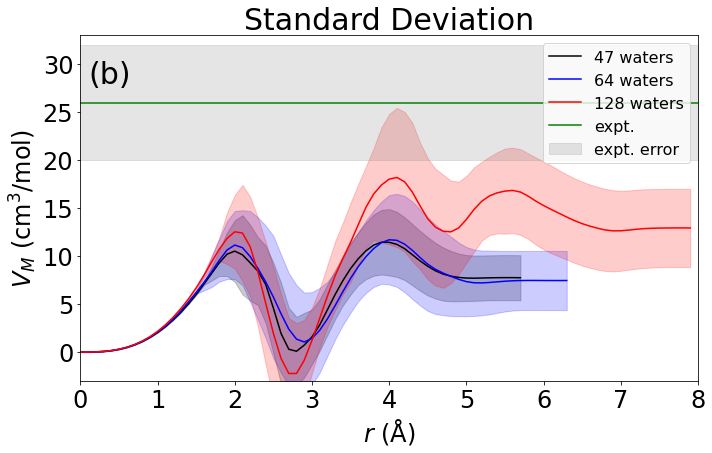

In [169]:
ri47_rmean = np.array([np.array(np.mean(np.array(ri47).T[i])) for i in range(len(np.array(ri47).T))])
ri47_rsd = np.array([np.array(np.std(np.array(ri47).T[i])) for i in range(len(np.array(ri47).T))])
ri64_rmean = np.array([np.array(np.mean(np.array(ri64).T[i])) for i in range(len(np.array(ri64).T))])
ri64_rsd = np.array([np.array(np.std(np.array(ri64).T[i])) for i in range(len(np.array(ri64).T))])
ri128_rmean = np.array([np.array(np.mean(np.array(ri128).T[i])) for i in range(len(np.array(ri128).T))])
ri128_rsd = np.array([np.array(np.std(np.array(ri128).T[i])) for i in range(len(np.array(ri128).T))])

plt.figure(figsize=(10,6))

ri_plt(ri47_rmean, ri47_rsd, br47, 'k', '47 waters')
ri_plt(ri64_rmean, ri64_rsd, br64, 'blue', '64 waters')
ri_plt(ri128_rmean, ri128_rsd, br128, 'red', '128 waters')

plt.plot([0,10], [26,26], label='expt.', color='g')
plt.fill_between([0,8], 20,32, alpha=.2, label='expt. error',color='grey')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('$\it{r}$ ($\AA$)', fontsize=24)
plt.ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
plt.ylim([-3,33])
plt.xlim([0,8])
plt.legend(fontsize=16, loc='upper right')
plt.text(.1, 28, '(b)', fontsize=30)
plt.tight_layout()
plt.title('Standard Deviation', fontsize=30)
#plt.savefig('./vm_cmt_data/figs/ri_rsd_newBins.pdf', format='pdf')
plt.show()

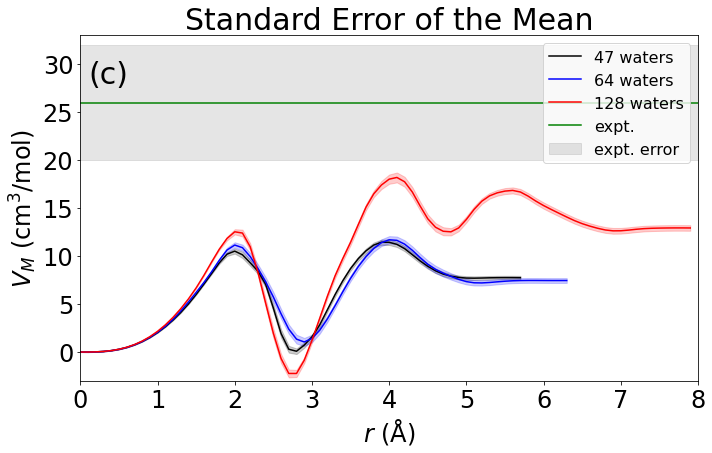

In [171]:
ri47_rmean = np.array([np.array(np.mean(np.array(ri47).T[i])) for i in range(len(np.array(ri47).T))])
ri47_rsem = np.array([np.array(np.std(np.array(ri47).T[i])/np.sqrt(len(np.array(ri47).T[i]))) for i in range(len(np.array(ri47).T))])
ri64_rmean = np.array([np.array(np.mean(np.array(ri64).T[i])) for i in range(len(np.array(ri64).T))])
ri64_rsem = np.array([np.array(np.std(np.array(ri64).T[i])/np.sqrt(len(np.array(ri64).T[i]))) for i in range(len(np.array(ri64).T))])
ri128_rmean = np.array([np.array(np.mean(np.array(ri128).T[i])) for i in range(len(np.array(ri128).T))])
ri128_rsem = np.array([np.array(np.std(np.array(ri128).T[i])/np.sqrt(len(np.array(ri128).T[i]))) for i in range(len(np.array(ri128).T))])

plt.figure(figsize=(10,6))

ri_plt(ri47_rmean, ri47_rsem, br47, 'k', '47 waters')
ri_plt(ri64_rmean, ri64_rsem, br64, 'blue', '64 waters')
ri_plt(ri128_rmean, ri128_rsem, br128, 'red', '128 waters')

plt.plot([0,10], [26,26], label='expt.', color='g')
plt.fill_between([0,8], 20,32, alpha=.2, label='expt. error',color='grey')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('$\it{r}$ ($\AA$)', fontsize=24)
plt.ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
plt.ylim([-3,33])
plt.xlim([0,8])
plt.legend(fontsize=16, loc='upper right')
plt.text(.1, 28, '(c)', fontsize=30)
plt.tight_layout()
plt.title('Standard Error of the Mean', fontsize=30)
#plt.savefig('./vm_cmt_data/figs/ri_rsem_newBins.pdf', format='pdf')
plt.show()

In [199]:
def ri_pltCI(ri_m, cih, cil, br, c, l):
    plt.plot(np.arange(0,br+.1,0.1), ri_m, color=c, label=l)
    plt.fill_between(np.arange(0,br+.1,0.1), cil, cih, alpha=.2, color=c)

In [25]:
from scipy import stats

In [203]:
np.array([np.mean(np.array(ri47).T[i]) for i in range(len(np.array(ri47).T))])[-1]

7.744558373299521

In [176]:
block_avg_err(np.array(ri47).T[-1])[2]

array(7.86520407)

In [191]:
st.t.interval(alpha=0.95, df=len(np.array(ri47).T[-1])-1, loc=np.mean(np.array(ri47).T[-1]), scale=st.sem(np.array(ri47).T[-1])) 

(7.365215060078477, 8.123901686520563)

/u/local/apps/python/3.9.6/gcc-4.8.5/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/u/local/apps/python/3.9.6/gcc-4.8.5/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


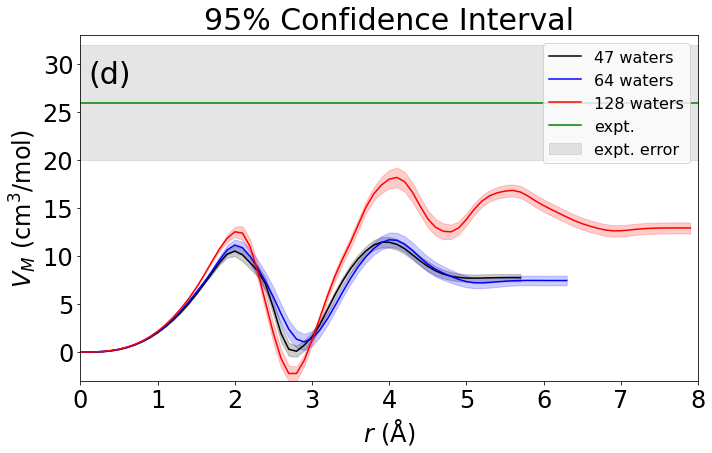

In [211]:
ri47_95cil = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri47).T[i])-1, loc=np.mean(np.array(ri47).T[i]), scale=st.sem(np.array(ri47).T[i])))[0] for i in range(len(np.array(ri47).T))])
ri47_95cih = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri47).T[i])-1, loc=np.mean(np.array(ri47).T[i]), scale=st.sem(np.array(ri47).T[i])))[1] for i in range(len(np.array(ri47).T))])

ri64_95cil = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri64).T[i])-1, loc=np.mean(np.array(ri64).T[i]), scale=st.sem(np.array(ri64).T[i])))[0] for i in range(len(np.array(ri64).T))])
ri64_95cih = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri64).T[i])-1, loc=np.mean(np.array(ri64).T[i]), scale=st.sem(np.array(ri64).T[i])))[1] for i in range(len(np.array(ri64).T))])

ri128_95cil = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri128).T[i])-1, loc=np.mean(np.array(ri128).T[i]), scale=st.sem(np.array(ri128).T[i])))[0] for i in range(len(np.array(ri128).T))])
ri128_95cih = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri128).T[i])-1, loc=np.mean(np.array(ri128).T[i]), scale=st.sem(np.array(ri128).T[i])))[1] for i in range(len(np.array(ri128).T))])

plt.figure(figsize=(10,6))

ri_pltCI(np.array([np.mean(np.array(ri47).T[i]) for i in range(len(np.array(ri47).T))]), ri47_95cil, ri47_95cih, br47, 'k', '47 waters')
ri_pltCI(np.array([np.mean(np.array(ri64).T[i]) for i in range(len(np.array(ri64).T))]), ri64_95cil, ri64_95cih, br64, 'b', '64 waters')
ri_pltCI(np.array([np.mean(np.array(ri128).T[i]) for i in range(len(np.array(ri128).T))]), ri128_95cil, ri128_95cih, br128, 'r', '128 waters')

plt.plot([0,10], [26,26], label='expt.', color='g')
plt.fill_between([0,8], 20,32, alpha=.2, label='expt. error',color='grey')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('$\it{r}$ ($\AA$)', fontsize=24)
plt.ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
plt.ylim([-3,33])
plt.xlim([0,8])
plt.legend(fontsize=16, loc='upper right')
plt.text(.1, 28, '(d)', fontsize=30)
plt.tight_layout()
plt.title('95% Confidence Interval', fontsize=30)
#plt.savefig('./vm_cmt_data/figs/ri_rsem_newBins.pdf', format='pdf')
plt.show()

In [ ]:
# full subplot

In [26]:
ri47 = [[vm_pbe0K2_rg(ardfs47[gr].results.rdf, ardfs47[gr].results.bins, br47, np.arange(0,br47+.1,0.1)[i]) for i in range(len(np.arange(0,br47+.1,0.1)))] for gr in range(len(ardfs47))]
ri64 = [[vm_pbe0K2_rg(ardfs64[gr].results.rdf, ardfs64[gr].results.bins, br64, np.arange(0,br64+.1,0.1)[i]) for i in range(len(np.arange(0,br64+.1,0.1)))] for gr in range(len(ardfs64))]
ri128 = [[vm_pbe0K2_rg(ardfs128[gr].results.rdf, ardfs128[gr].results.bins, br128, np.arange(0,br128+.1,0.1)[i]) for i in range(len(np.arange(0,br128+.1,0.1)))] for gr in range(len(ardfs128))]

In [27]:
ri47_rmean = np.array([np.array(np.mean(np.array(ri47).T[i])) for i in range(len(np.array(ri47).T))])
ri47_rsd = np.array([np.array(np.std(np.array(ri47).T[i])) for i in range(len(np.array(ri47).T))])
ri64_rmean = np.array([np.array(np.mean(np.array(ri64).T[i])) for i in range(len(np.array(ri64).T))])
ri64_rsd = np.array([np.array(np.std(np.array(ri64).T[i])) for i in range(len(np.array(ri64).T))])
ri128_rmean = np.array([np.array(np.mean(np.array(ri128).T[i])) for i in range(len(np.array(ri128).T))])
ri128_rsd = np.array([np.array(np.std(np.array(ri128).T[i])) for i in range(len(np.array(ri128).T))])

In [28]:
ri47_rmean = np.array([np.array(np.mean(np.array(ri47).T[i])) for i in range(len(np.array(ri47).T))])
ri47_rsem = np.array([np.array(np.std(np.array(ri47).T[i])/np.sqrt(len(np.array(ri47).T[i]))) for i in range(len(np.array(ri47).T))])
ri64_rmean = np.array([np.array(np.mean(np.array(ri64).T[i])) for i in range(len(np.array(ri64).T))])
ri64_rsem = np.array([np.array(np.std(np.array(ri64).T[i])/np.sqrt(len(np.array(ri64).T[i]))) for i in range(len(np.array(ri64).T))])
ri128_rmean = np.array([np.array(np.mean(np.array(ri128).T[i])) for i in range(len(np.array(ri128).T))])
ri128_rsem = np.array([np.array(np.std(np.array(ri128).T[i])/np.sqrt(len(np.array(ri128).T[i]))) for i in range(len(np.array(ri128).T))])

In [30]:
ri47_95cil = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri47).T[i])-1, loc=np.mean(np.array(ri47).T[i]), scale=st.sem(np.array(ri47).T[i])))[0] for i in range(len(np.array(ri47).T))])
ri47_95cih = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri47).T[i])-1, loc=np.mean(np.array(ri47).T[i]), scale=st.sem(np.array(ri47).T[i])))[1] for i in range(len(np.array(ri47).T))])

ri64_95cil = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri64).T[i])-1, loc=np.mean(np.array(ri64).T[i]), scale=st.sem(np.array(ri64).T[i])))[0] for i in range(len(np.array(ri64).T))])
ri64_95cih = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri64).T[i])-1, loc=np.mean(np.array(ri64).T[i]), scale=st.sem(np.array(ri64).T[i])))[1] for i in range(len(np.array(ri64).T))])

ri128_95cil = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri128).T[i])-1, loc=np.mean(np.array(ri128).T[i]), scale=st.sem(np.array(ri128).T[i])))[0] for i in range(len(np.array(ri128).T))])
ri128_95cih = np.array([list(st.t.interval(alpha=0.95, df=len(np.array(ri128).T[i])-1, loc=np.mean(np.array(ri128).T[i]), scale=st.sem(np.array(ri128).T[i])))[1] for i in range(len(np.array(ri128).T))])

/u/local/apps/python/3.9.6/gcc-4.8.5/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/u/local/apps/python/3.9.6/gcc-4.8.5/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.

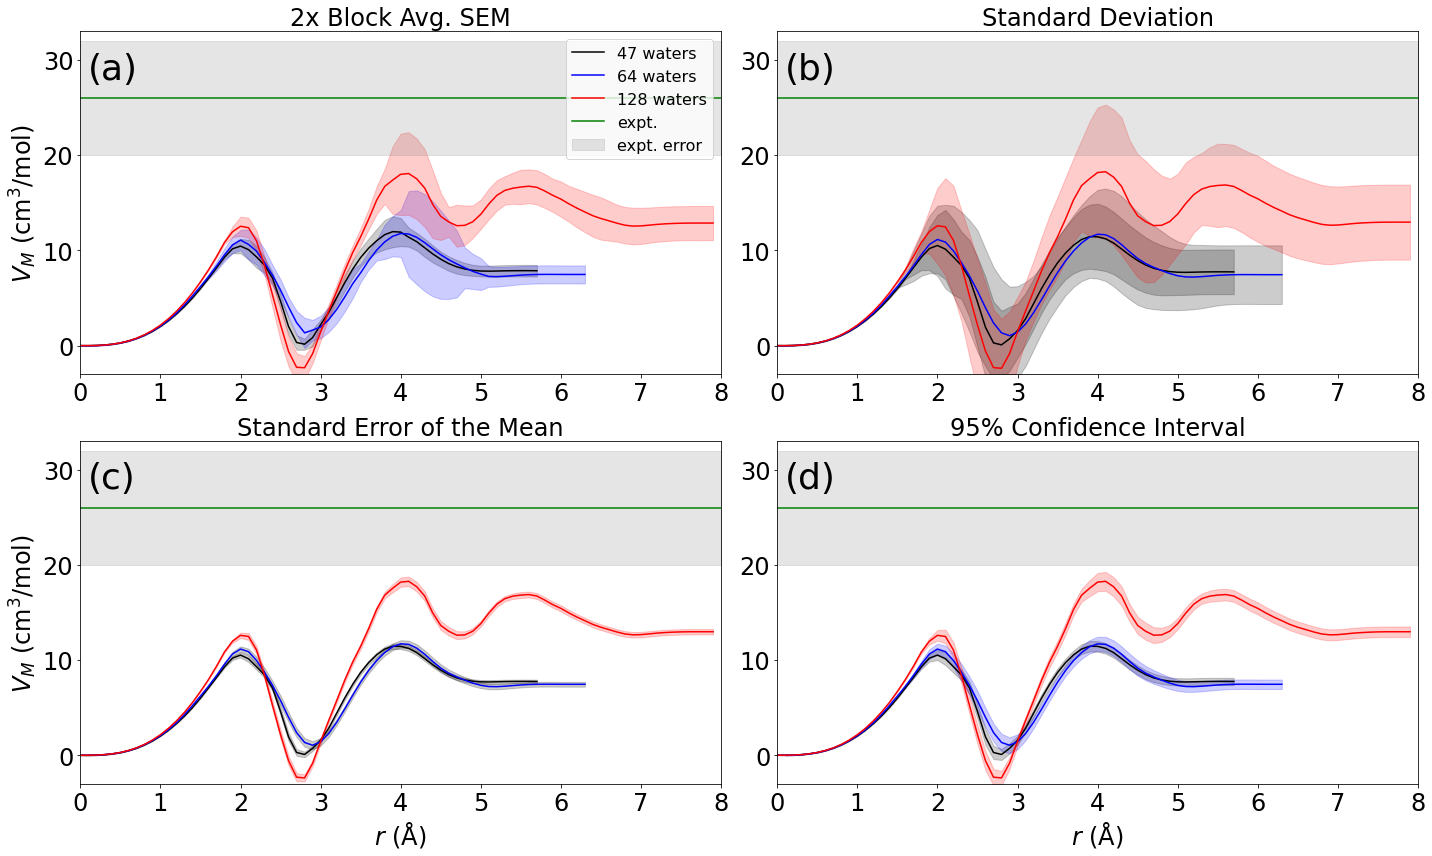

In [40]:
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,12))


axs[0,0].plot(np.arange(0,br47+.1,0.1), np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))]), color='k', label='47 waters')
axs[0,0].fill_between(np.arange(0,br47+.1,0.1), np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))])-np.array([np.array(block_avg_err(np.array(ri47).T[i])[4]*2) for i in range(len(np.array(ri47).T))]), np.array([np.array(block_avg_err(np.array(ri47).T[i])[2]) for i in range(len(np.array(ri47).T))])+np.array([np.array(block_avg_err(np.array(ri47).T[i])[4]*2) for i in range(len(np.array(ri47).T))]), alpha=.2, color='k')

axs[0,0].plot(np.arange(0,br64+.1,0.1), np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))]), color='blue', label='64 waters')
axs[0,0].fill_between(np.arange(0,br64+.1,0.1), np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))])-np.array([np.array(block_avg_err(np.array(ri64).T[i])[4]*2) for i in range(len(np.array(ri64).T))]), 
                 np.array([np.array(block_avg_err(np.array(ri64).T[i])[2]) for i in range(len(np.array(ri64).T))])+np.array([np.array(block_avg_err(np.array(ri64).T[i])[4]*2) for i in range(len(np.array(ri64).T))]), alpha=.2, color='blue')

axs[0,0].plot(np.arange(0,br128+.1,0.1), np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))]), color='red', label='128 waters')
axs[0,0].fill_between(np.arange(0,br128+.1,0.1), np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))])-np.array([np.array(block_avg_err(np.array(ri128).T[i])[4]*2) for i in range(len(np.array(ri128).T))]), 
                 np.array([np.array(block_avg_err(np.array(ri128).T[i])[2]) for i in range(len(np.array(ri128).T))])+np.array([np.array(block_avg_err(np.array(ri128).T[i])[4]*2) for i in range(len(np.array(ri128).T))]), alpha=.2, color='red')

axs[0,0].plot([0,10], [26,26], label='expt.', color='g')
axs[0,0].fill_between([0,8], 20,32, alpha=.2, label='expt. error',color='grey')
axs[0,0].legend(fontsize=16, loc='upper right')

#axs[0,0].set_xlabel('$\it{r}$ ($\AA$)', fontsize=24)
axs[0,0].set_ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
axs[0,0].set_ylim([-3,33])
axs[0,0].set_xlim([0,8])
axs[0,0].text(.1, 28, '(a)', fontsize=36)
axs[0,0].set_title('2x Block Avg. SEM', fontsize=24)

###

axs[0,1].plot(np.arange(0,br47+.1,0.1), ri47_rmean, color='k', label='47 waters')
axs[0,1].fill_between(np.arange(0,br47+.1,0.1), ri47_rmean-ri47_rsd, ri47_rmean+ri47_rsd, alpha=.2, color='k')
axs[0,1].plot(np.arange(0,br64+.1,0.1), ri64_rmean, color='b', label='64 waters')
axs[0,1].fill_between(np.arange(0,br64+.1,0.1), ri64_rmean-ri64_rsd, ri64_rmean+ri64_rsd, alpha=.2, color='k')
axs[0,1].plot(np.arange(0,br128+.1,0.1), ri128_rmean, color='r', label='128 waters')
axs[0,1].fill_between(np.arange(0,br128+.1,0.1), ri128_rmean-ri128_rsd, ri128_rmean+ri128_rsd, alpha=.2, color='r')
axs[0,1].set_ylim([-3,33])
axs[0,1].set_xlim([0,8])
axs[0,1].plot([0,10], [26,26], label='expt.', color='g')
axs[0,1].fill_between([0,8], 20,32, alpha=.2, label='expt. error',color='grey')
axs[0,1].text(.1, 28, '(b)', fontsize=36)
axs[0,1].set_title('Standard Deviation', fontsize=24)

###

axs[1,0].plot(np.arange(0,br47+.1,0.1), ri47_rmean, color='k', label='47 waters')
axs[1,0].fill_between(np.arange(0,br47+.1,0.1), ri47_rmean-ri47_rsem, ri47_rmean+ri47_rsem, alpha=.2, color='k')
axs[1,0].plot(np.arange(0,br64+.1,0.1), ri64_rmean, color='b', label='64 waters')
axs[1,0].fill_between(np.arange(0,br64+.1,0.1), ri64_rmean-ri64_rsem, ri64_rmean+ri64_rsem, alpha=.2, color='k')
axs[1,0].plot(np.arange(0,br128+.1,0.1), ri128_rmean, color='r', label='128 waters')
axs[1,0].fill_between(np.arange(0,br128+.1,0.1), ri128_rmean-ri128_rsem, ri128_rmean+ri128_rsem, alpha=.2, color='r')
axs[1,0].set_ylim([-3,33])
axs[1,0].set_xlim([0,8])
axs[1,0].set_xlabel('$\it{r}$ ($\AA$)', fontsize=24)
axs[1,0].plot([0,10], [26,26], label='expt.', color='g')
axs[1,0].fill_between([0,8], 20,32, alpha=.2, label='expt. error',color='grey')
axs[1,0].text(.1, 28, '(c)', fontsize=36)
axs[1,0].set_title('Standard Error of the Mean', fontsize=24)
axs[1,0].set_ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)

###

axs[1,1].plot(np.arange(0,br47+.1,0.1), ri47_rmean, color='k', label='47 waters')
axs[1,1].fill_between(np.arange(0,br47+.1,0.1), ri47_95cil, ri47_95cih, alpha=.2, color='k')
axs[1,1].plot(np.arange(0,br64+.1,0.1), ri64_rmean, color='b', label='64 waters')
axs[1,1].fill_between(np.arange(0,br64+.1,0.1), ri64_95cil, ri64_95cih, alpha=.2, color='b')
axs[1,1].plot(np.arange(0,br128+.1,0.1), ri128_rmean, color='r', label='128 waters')
axs[1,1].fill_between(np.arange(0,br128+.1,0.1), ri128_95cil, ri128_95cih, alpha=.2, color='r')
axs[1,1].set_xlabel('$\it{r}$ ($\AA$)', fontsize=24)
axs[1,1].set_ylim([-3,33])
axs[1,1].set_xlim([0,8])
axs[1,1].plot([0,10], [26,26], label='expt.', color='g')
axs[1,1].fill_between([0,8], 20,32, alpha=.2, label='expt. error',color='grey')
axs[1,1].text(.1, 28, '(d)', fontsize=36)
axs[1,1].set_title('95% Confidence Interval', fontsize=24)

###

plt.tight_layout()
#plt.savefig('./vm_cmt_data/figs/ri_diffErrs_newBins.pdf', format='pdf')
plt.show()

## Contributions

### Old Grs

<IPython.core.display.Javascript object>


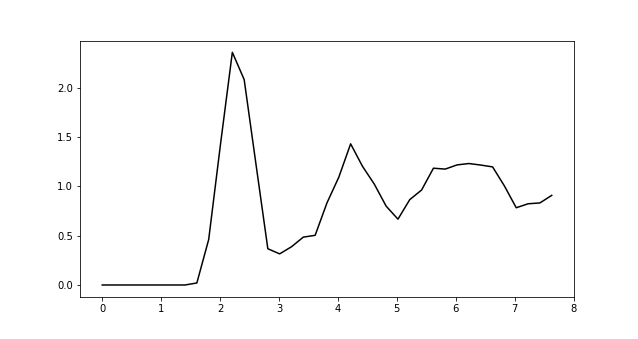

In [84]:
%matplotlib notebook
plt.plot(gr_128_f[:,0], gr_128_f[:,1], color='k')
plt.show()

In [63]:
ends_47 = [1.97, 3.29, 5.16]
inits_47 = [0.0, 1.97, 3.29]
all_conts_47 = []
for rdf in range(len(grs47_orig)):
    tconts_47 = [vm_pbe0K2(grs47_orig[rdf], br47, ends_47[i], inits_47[i]) for i in range(len(ends_47))]
    tconts_47.append(0.0)
    all_conts_47.append(tconts_47)

ends_64 = [2.00, 3.33, 5.41]
inits_64 = [0.0, 2.00, 3.33]
all_conts_64 = []
for rdf in range(len(grs64_orig)):
    tconts_64 = [vm_pbe0K2(grs64_orig[rdf], br64, ends_64[i], inits_64[i]) for i in range(len(ends_64))]
    tconts_64.append(0.0)
    all_conts_64.append(tconts_64)


ends_128 = [2.0, 2.92, 5.09, 7.14]
inits_128 = [0.0, 2.0, 2.92, 5.09]
all_conts_128 = []
for rdf in range(len(grs128_orig)):
    tconts_128 = [vm_pbe0K2(grs128_orig[rdf], br128, ends_128[i], inits_128[i]) for i in range(len(ends_128))]
    all_conts_128.append(tconts_128)

%matplotlib inline
plt.figure(figsize=(12,10))
x = np.arange(len(np.array(all_conts_128).T))
y1 = np.array([np.array(block_avg_err(np.array(all_conts_47).T[i])[2]) for i in range(len(np.array(all_conts_47).T))])
y1_err = np.array([np.array(block_avg_err(np.array(all_conts_47).T[i])[4]*2) for i in range(len(np.array(all_conts_47).T))])
y2 = np.array([np.array(block_avg_err(np.array(all_conts_64).T[i])[2]) for i in range(len(np.array(all_conts_64).T))])
y2_err = np.array([np.array(block_avg_err(np.array(all_conts_64).T[i])[4]*2) for i in range(len(np.array(all_conts_64).T))])
y3 = np.array([np.array(block_avg_err(np.array(all_conts_128).T[i])[2]) for i in range(len(np.array(all_conts_128).T))])
y3_err = np.array([np.array(block_avg_err(np.array(all_conts_128).T[i])[4]*2) for i in range(len(np.array(all_conts_128).T))])
width = 0.20
  
plt.bar(x-0.2, y1, width, label='47 waters', color='k', yerr=y1_err)
plt.bar(x, y2, width, label='64 waters', color='b', yerr=y2_err)
plt.bar(x+0.2, y3, width, label='128 waters', color='r', yerr=y3_err)

plt.xticks(x, ['cavity','1$^{st}$ shell','2$^{nd}$ shell','3$^{rd}$ shell'], fontsize=24)
plt.hlines(0, -.3, 3.3, color='k')

plt.ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
plt.legend(fontsize=26, loc='lower right')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.text(-.45, 16, '(b)', fontsize=36)
#plt.savefig('/mnt/d/DesktopFiles/UCLA_rsrch/schwartz/KB_molar_vol/figs/conts_ba.pdf', format='pdf')
plt.show()

NameError: name 'grs47_orig' is not defined

### New grs

/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:


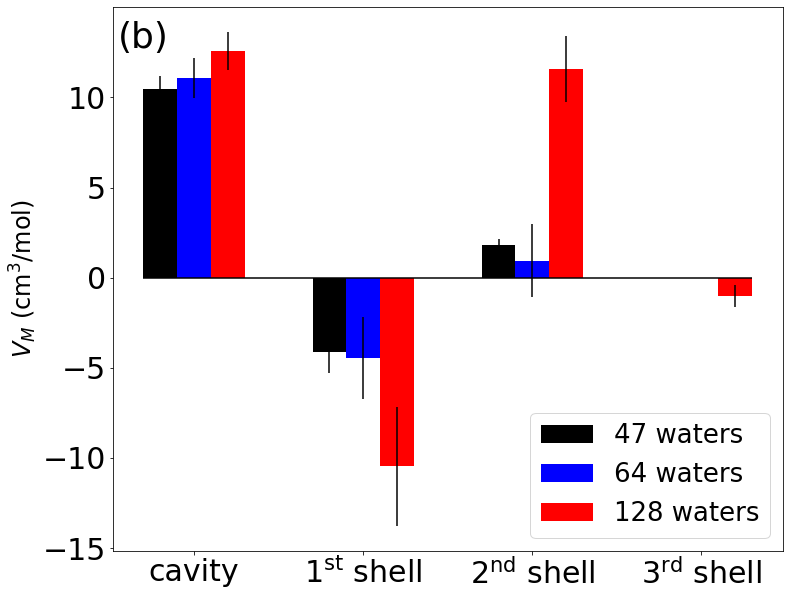

In [43]:
ends_47 = [1.99, 3.27, 5.37]
inits_47 = [0.0, 1.99, 3.27]
all_conts_47 = []
for rdf in range(len(ardfs47)):
    tconts_47 = [vm_pbe0K2_rg(ardfs47[rdf].results.rdf, ardfs47[rdf].results.bins, br47, ends_47[i], inits_47[i]) for i in range(len(ends_47))]
    tconts_47.append(0.0)
    all_conts_47.append(tconts_47)

ends_64 = [2.02, 3.40, 5.40]
inits_64 = [0.0, 2.02, 3.40]
all_conts_64 = []
for rdf in range(len(ardfs64)):
    tconts_64 = [vm_pbe0K2_rg(ardfs64[rdf].results.rdf, ardfs64[rdf].results.bins, br64, ends_64[i], inits_64[i]) for i in range(len(ends_64))]
    tconts_64.append(0.0)
    all_conts_64.append(tconts_64)

ends_128 = [2.02, 3.03, 4.99, 7.13]
inits_128 = [0.0, 2.02, 3.03, 4.99]
all_conts_128 = []
for rdf in range(len(ardfs128)):
    tconts_128 = [vm_pbe0K2_rg(ardfs128[rdf].results.rdf, ardfs128[rdf].results.bins, br128, ends_128[i], inits_128[i]) for i in range(len(ends_128))]
    all_conts_128.append(tconts_128)

%matplotlib inline
plt.figure(figsize=(12,10))
x = np.arange(len(np.array(all_conts_128).T))
y1 = np.array([np.array(block_avg_err(np.array(all_conts_47).T[i])[2]) for i in range(len(np.array(all_conts_47).T))])
y1_err = np.array([np.array(block_avg_err(np.array(all_conts_47).T[i])[4]*2) for i in range(len(np.array(all_conts_47).T))])
y2 = np.array([np.array(block_avg_err(np.array(all_conts_64).T[i])[2]) for i in range(len(np.array(all_conts_64).T))])
y2_err = np.array([np.array(block_avg_err(np.array(all_conts_64).T[i])[4]*2) for i in range(len(np.array(all_conts_64).T))])
y3 = np.array([np.array(block_avg_err(np.array(all_conts_128).T[i])[2]) for i in range(len(np.array(all_conts_128).T))])
y3_err = np.array([np.array(block_avg_err(np.array(all_conts_128).T[i])[4]*2) for i in range(len(np.array(all_conts_128).T))])
width = 0.20
  
plt.bar(x-0.2, y1, width, label='47 waters', color='k', yerr=y1_err)
plt.bar(x, y2, width, label='64 waters', color='b', yerr=y2_err)
plt.bar(x+0.2, y3, width, label='128 waters', color='r', yerr=y3_err)

plt.xticks(x, ['cavity','1$^{st}$ shell','2$^{nd}$ shell','3$^{rd}$ shell'], fontsize=24)
plt.hlines(0, -.3, 3.3, color='k')

plt.ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
plt.legend(fontsize=26, loc='lower right')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.text(-.45, 12.75, '(b)', fontsize=36)
#plt.savefig('./vm_cmt_data/figs/conts_2tba_newBins.pdf', format='pdf')
plt.show()

In [45]:
y3

array([ 12.58388283, -10.46466086,  11.57816206,  -1.02074205])

# Extrapolation

## Old Grs

In [89]:
ri47 = [[vm_pbe0K2(grs47_orig[gr], br47, np.arange(0,br47+.1,0.1)[i]) for i in range(len(np.arange(0,br47+.1,0.1)))] for gr in range(len(grs47_orig))]
ri64 = [[vm_pbe0K2(grs64_orig[gr], br64, np.arange(0,br64+.1,0.1)[i]) for i in range(len(np.arange(0,br64+.1,0.1)))] for gr in range(len(grs64_orig))]
ri128 = [[vm_pbe0K2(grs128_orig[gr], br128, np.arange(0,br128+.1,0.1)[i]) for i in range(len(np.arange(0,br128+.1,0.1)))] for gr in range(len(grs128_orig))]

inv_ls = [1/(2*br128),1/(2*br64),1/(2*br47)]
x = inv_ls
x.insert(0,0)
result = linregress([1/(2*br128),1/(2*br64),1/(2*br47)], [block_avg_err(np.array(ri128).T[-1])[2], block_avg_err(np.array(ri64).T[-1])[2], block_avg_err(np.array(ri47).T[-1])[2]])
result

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)


LinregressResult(slope=-213.30927906522734, intercept=26.03580861908003, rvalue=-0.9086839217603907, pvalue=0.27417657587225036, stderr=98.00258643221518, intercept_stderr=7.677880464263315)

In [90]:
[block_avg_err(np.array(ri128).T[-1])[2], block_avg_err(np.array(ri64).T[-1])[2], block_avg_err(np.array(ri47).T[-1])[2]]

[array(12.94139194), array(7.56356718), array(7.91725394)]

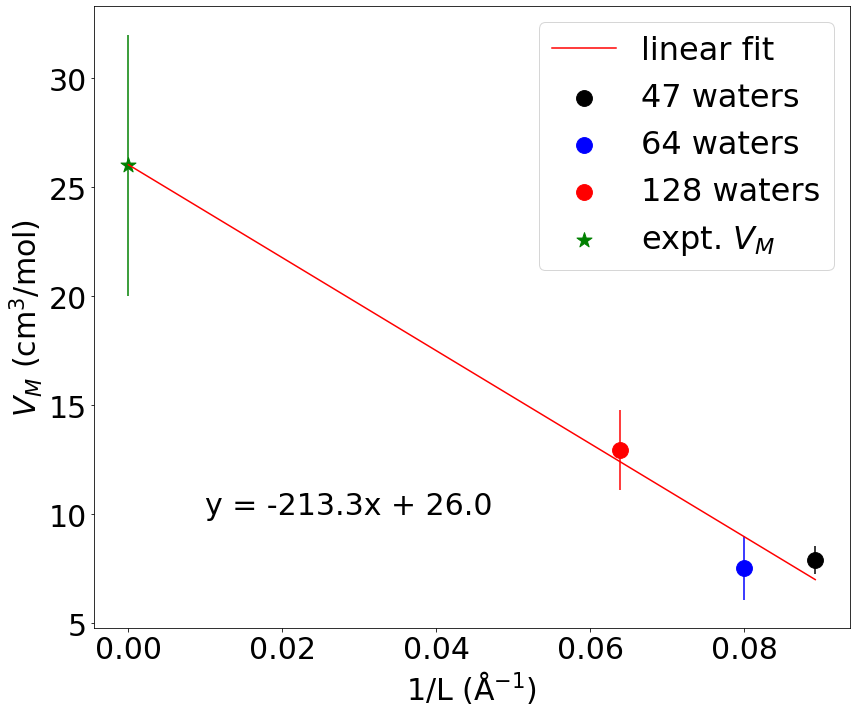

In [92]:
plt.figure(figsize=(12,10))

plt.scatter(1/(2*br47), block_avg_err(np.array(ri47).T[-1])[2], label='47 waters',s=250,c='k')
plt.errorbar(1/(2*br47), block_avg_err(np.array(ri47).T[-1])[2], yerr = block_avg_err(np.array(ri47).T[-1])[4]*2,c='k')

plt.scatter(1/(2*br64), block_avg_err(np.array(ri64).T[-1])[2], label='64 waters',s=250,c='blue')
plt.errorbar(1/(2*br64), block_avg_err(np.array(ri64).T[-1])[2], yerr = block_avg_err(np.array(ri64).T[-1])[4]*2,c='blue')

plt.scatter(1/(2*br128), block_avg_err(np.array(ri128).T[-1])[2], label='128 waters',s=250,c='red')
plt.errorbar(1/(2*br128), block_avg_err(np.array(ri128).T[-1])[2], yerr = block_avg_err(np.array(ri128).T[-1])[4]*2,c='red')

plt.scatter(0.0, 26, label='expt. $\it{V_M}$',s=250,marker='*',c='green')
plt.errorbar(0.0, 26, 6, c='green')

plt.plot(x, result.intercept + result.slope*np.array(x), 'r', label='linear fit')

plt.xlabel('$1/L$ ($\AA^{-1}$)', fontsize=30)
plt.ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=30)
plt.legend()

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=32)
plt.text(.01, 10, 'y = '+str(round(result[0],1))+'x + '+str(round(result[1],1)), fontsize=30)
plt.tight_layout()

#plt.savefig('/mnt/d/DesktopFiles/UCLA_rsrch/schwartz/KB_molar_vol/figs/extrap_ba.pdf', format='pdf')
plt.show()

## new grs

In [38]:
ri47 = [[vm_pbe0K2_rg(gr_47_yindv[gr], gr_47_f[:,0], br47, np.arange(0,br47+.1,0.1)[i]) for i in range(len(np.arange(0,br47+.1,0.1)))] for gr in range(len(gr_47_yindv))]
ri64 = [[vm_pbe0K2_rg(gr_64_yindv[gr], gr_64_f[:,0], br64, np.arange(0,br64+.1,0.1)[i]) for i in range(len(np.arange(0,br64+.1,0.1)))] for gr in range(len(gr_64_yindv))]
ri128 = [[vm_pbe0K2_rg(gr_128_yindv[gr], gr_128_f[:,0], br128, np.arange(0,br128+.1,0.1)[i]) for i in range(len(np.arange(0,br128+.1,0.1)))] for gr in range(len(gr_128_yindv))]
# with block avging

inv_ls = [1/(2*br128),1/(2*br64),1/(2*br47)]
x = inv_ls
x.insert(0,0)
result = linregress([1/(2*br128),1/(2*br64),1/(2*br47)], [block_avg_err(np.array(ri128).T[-1])[2], block_avg_err(np.array(ri64).T[-1])[2], block_avg_err(np.array(ri47).T[-1])[2]])
result

LinregressResult(slope=-236.08176456296877, intercept=26.632180115631783, rvalue=-0.8585111763050942, pvalue=0.3427797044451558, stderr=141.01332264762925, intercept_stderr=11.047498587253562)

In [39]:
[block_avg_err(np.array(ri128).T[-1])[2], block_avg_err(np.array(ri64).T[-1])[2], block_avg_err(np.array(ri47).T[-1])[2]]

[array(12.31480903), array(5.71182433), array(6.8803971)]

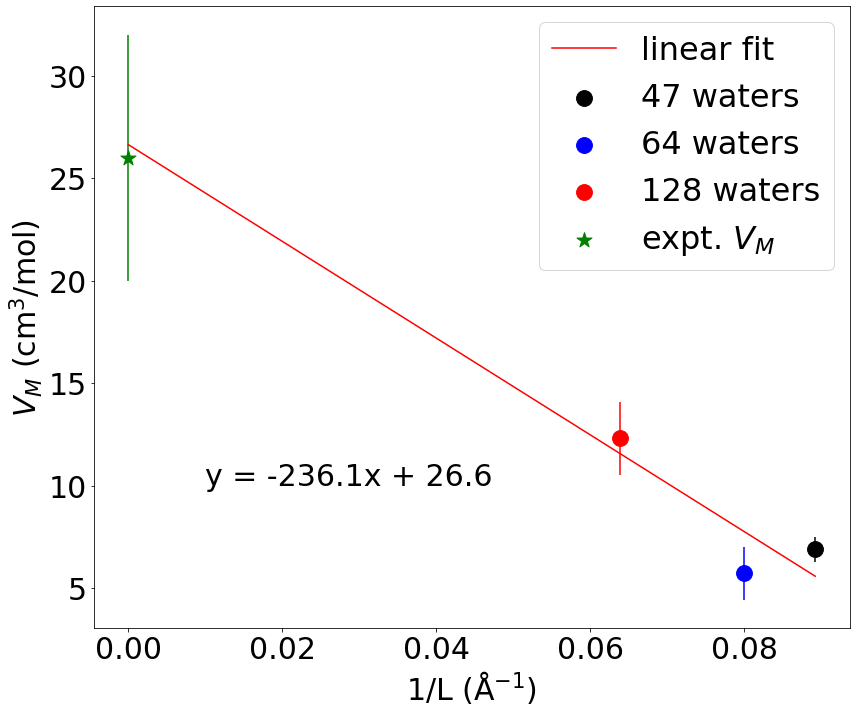

In [40]:
plt.figure(figsize=(12,10))

plt.scatter(1/(2*br47), block_avg_err(np.array(ri47).T[-1])[2], label='47 waters',s=250,c='k')
plt.errorbar(1/(2*br47), block_avg_err(np.array(ri47).T[-1])[2], yerr = block_avg_err(np.array(ri47).T[-1])[4]*2,c='k')

plt.scatter(1/(2*br64), block_avg_err(np.array(ri64).T[-1])[2], label='64 waters',s=250,c='blue')
plt.errorbar(1/(2*br64), block_avg_err(np.array(ri64).T[-1])[2], yerr = block_avg_err(np.array(ri64).T[-1])[4]*2,c='blue')

plt.scatter(1/(2*br128), block_avg_err(np.array(ri128).T[-1])[2], label='128 waters',s=250,c='red')
plt.errorbar(1/(2*br128), block_avg_err(np.array(ri128).T[-1])[2], yerr = block_avg_err(np.array(ri128).T[-1])[4]*2,c='red')

plt.scatter(0.0, 26, label='expt. $\it{V_M}$',s=250,marker='*',c='green')
plt.errorbar(0.0, 26, 6, c='green')

plt.plot(x, result.intercept + result.slope*np.array(x), 'r', label='linear fit')

plt.xlabel('$1/L$ ($\AA^{-1}$)', fontsize=30)
plt.ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=30)
plt.legend()

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=32)
plt.text(.01, 10, 'y = '+str(round(result[0],1))+'x + '+str(round(result[1],1)), fontsize=30)
plt.tight_layout()

#plt.savefig('./vm_cmt_data/figs/extrap_2tba.pdf', format='pdf')
plt.show()

## MDanalysis rDFs

In [135]:
np.array([vmb128[2], vmb64[2], vmb47[2]])

array([12.87263487,  7.47523493,  7.87232849])

In [136]:
inv_ls = [1/(2*br128),1/(2*br64),1/(2*br47)]
x = inv_ls
x.insert(0,0)
result = linregress([1/(2*br128),1/(2*br64),1/(2*br47)], np.array([vmb128[2], vmb64[2], vmb47[2]]))
result

LinregressResult(slope=-212.6045362995552, intercept=25.91375279524088, rvalue=-0.9056432515999736, pvalue=0.2787771327884852, stderr=99.54573446264125, intercept_stderr=7.798776315562807)

In [47]:
[bc47, bc64, bc128]

[35, 25, 60]

In [3]:
plt.figure(figsize=(12,10))

plt.scatter(1/(2*br47), vmb47[2], label='47 waters',s=250,c='k')
plt.errorbar(1/(2*br47), vmb47[2], yerr = vmb47[4]*2,c='k')

plt.scatter(1/(2*br64), vmb64[2], label='64 waters',s=250,c='blue')
plt.errorbar(1/(2*br64), vmb64[2], yerr = vmb64[4]*2,c='blue')

plt.scatter(1/(2*br128), vmb128[2], label='128 waters',s=250,c='red')
plt.errorbar(1/(2*br128), vmb128[2], yerr = vmb128[4]*2,c='red')

plt.scatter(0.0, 21.2, label='expt. $\it{V_M}$',s=250,marker='*',c='green')
plt.errorbar(0.0, 21.2, 6, c='green')

plt.plot(x, result.intercept + result.slope*np.array(x), 'r', label='linear fit')

plt.xlabel('$1/L$ ($\AA^{-1}$)', fontsize=30)
plt.ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=30)
plt.legend()

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=32)
plt.text(.01, 10, 'y = '+str(round(result[0],1))+'x + '+str(round(result[1],1)), fontsize=30)
plt.tight_layout()

#plt.savefig('./vm_cmt_data/figs/extrap_2tba_newBins.pdf', format='pdf')
plt.show()

NameError: name 'plt' is not defined

# SI Figs

## Bin Size Convergence

### with blk avg. mean and std.

In [61]:
vms_bc_47 = []
vmErs_bc_47 = []

vms_bc_64 = []
vmErs_bc_64 = []

vms_bc_128 = []
vmErs_bc_128 = []

for bc in range(10,160,10):
    trdfs47 = all_rdfs(u47, br47, br47, bc)
    t47_res = np.array(block_avg_err(np.array([vm_pbe0K2_rg(trdfs47[ts].rdf, trdfs47[ts].bins, br47, br47) for ts in range(len(trdfs47))])))
    vms_bc_47.append(t47_res[2])
    vmErs_bc_47.append(t47_res[4]*2)
    
    trdfs64 = all_rdfs(u64, br64, br64, bc)
    t64_res = np.array(block_avg_err(np.array([vm_pbe0K2_rg(trdfs64[ts].rdf, trdfs64[ts].bins, br64, br64) for ts in range(len(trdfs64))])))
    vms_bc_64.append(t64_res[2])
    vmErs_bc_64.append(t64_res[4]*2)
    
    trdfs128 = all_rdfs(u128, br128, br128, bc)
    t128_res = np.array(block_avg_err(np.array([vm_pbe0K2_rg(trdfs128[ts].rdf, trdfs128[ts].bins, br128, br128) for ts in range(len(trdfs128))])))
    vms_bc_128.append(t128_res[2])
    vmErs_bc_128.append(t128_res[4]*2)

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)


In [62]:
[vmb47[2], vmb64[2], vmb128[2]]

[array(7.87232849), array(7.47523493), array(12.85005462)]

In [63]:
[vms_bc_47[-1], vms_bc_64[-1], vms_bc_128[-1]]

[7.9127621565431605, 7.559709936270028, 12.91964557562124]

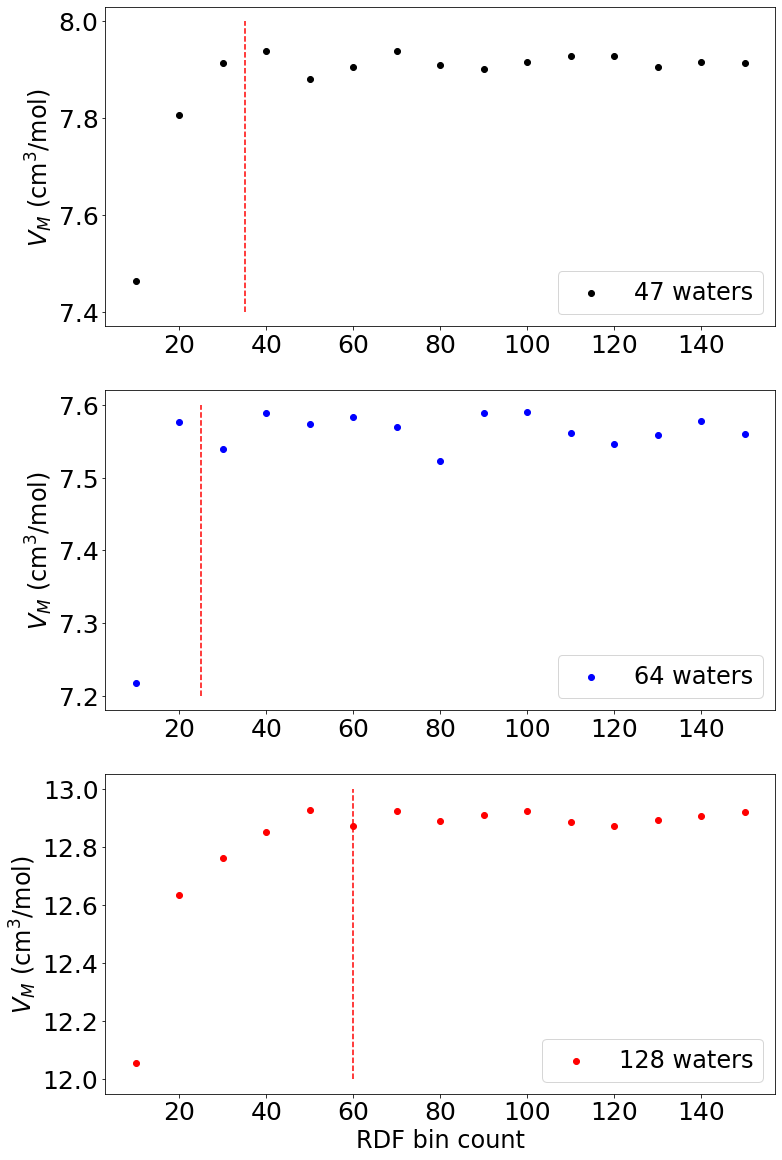

In [143]:
fig, axs = plt.subplots(3, 1, figsize=(12, 20))

axs[0].scatter(range(10,160,10), vms_bc_47, label='47 waters', c='k')
axs[0].legend(loc='lower right', fontsize=24)
#axs[0].set_xlabel('RDF bin count', fontsize=24)
axs[0].set_ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
axs[0].tick_params(labelsize=25)
axs[0].vlines(bc47, 7.4, 8, color='r', linestyle='--')

axs[1].scatter(range(10,160,10), vms_bc_64, label='64 waters', c='blue')
axs[1].legend(loc='lower right', fontsize=24)
#axs[1].set_xlabel('RDF bin count', fontsize=24)
axs[1].set_ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
axs[1].tick_params(labelsize=25)
axs[1].vlines(bc64, 7.2, 7.6, color='r', linestyle='--')

axs[2].scatter(range(10,160,10), vms_bc_128, label='128 waters', c='r')
axs[2].legend(loc='lower right', fontsize=24)
axs[2].set_xlabel('RDF bin count', fontsize=24)
axs[2].set_ylabel('$\it{V_M}$ (cm$^3$/mol)', fontsize=24)
axs[2].tick_params(labelsize=25)
axs[2].vlines(bc128, 12., 13, color='r', linestyle='--')

#plt.savefig('./vm_cmt_data/figs/binCtConv_newBins.pdf', format='pdf')
plt.show()

In [118]:
bc128

40

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn

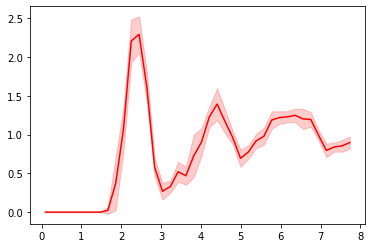

In [120]:
tardfs128 = all_rdfs(u128, br128, br128, bc128)

plt.plot(tardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T))),
        label='128 waters', color='r')
plt.fill_between(tardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))-2*np.array(list(map(map_blk_err, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T))),
                 np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))+2*np.array(list(map(map_blk_err, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))
                 , alpha=0.2, color='r')

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn

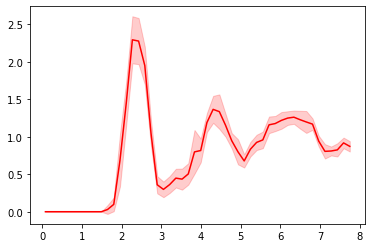

In [119]:
tardfs128 = all_rdfs(u128, br128, br128, 50)

plt.plot(tardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T))),
        label='128 waters', color='r')
plt.fill_between(tardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))-2*np.array(list(map(map_blk_err, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T))),
                 np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))+2*np.array(list(map(map_blk_err, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))
                 , alpha=0.2, color='r')

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn

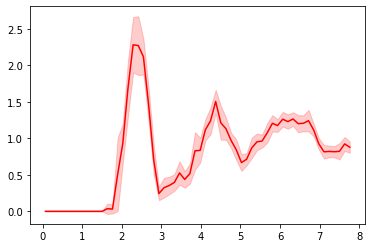

In [121]:
tardfs128 = all_rdfs(u128, br128, br128, 60)

plt.plot(tardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T))),
        label='128 waters', color='r')
plt.fill_between(tardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))-2*np.array(list(map(map_blk_err, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T))),
                 np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))+2*np.array(list(map(map_blk_err, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))
                 , alpha=0.2, color='r')

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn

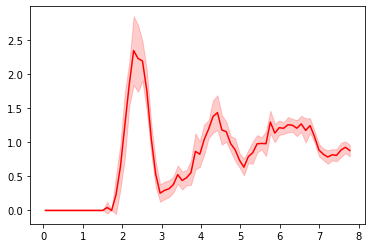

In [122]:
tardfs128 = all_rdfs(u128, br128, br128, 70)

plt.plot(tardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T))),
        label='128 waters', color='r')
plt.fill_between(tardfs128[0].bins, np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))-2*np.array(list(map(map_blk_err, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T))),
                 np.array(list(map(map_blk_avg, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))+2*np.array(list(map(map_blk_err, np.array([tardfs128[i].rdf for i in range(len(tardfs128))]).T)))
                 , alpha=0.2, color='r')